# ex1

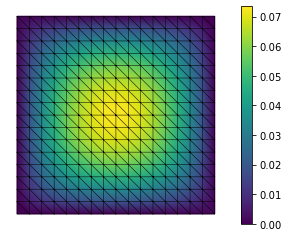

In [7]:
from skfem import *
from skfem.models.poisson import laplace, unit_load

m = MeshTri()
m.refine(4)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x = solve(*condense(A, b, I=m.interior_nodes()))

if __name__ == "__main__":
    from os.path import splitext
    from sys import argv
    from skfem.visuals.matplotlib import plot, savefig
    ax = draw(m)
    plot(m, x, shading='gouraud', colorbar=True,ax=ax)
    savefig(splitext(argv[0])[0] + '_solution.png')


# Example 2:
This example demonstrates the solution of a slightly more complicated problem
with multiple boundary conditions and a fourth-order differential operator. We
consider the `Kirchhoff plate bending problem
<https://en.wikipedia.org/wiki/Kirchhoff%E2%80%93Love_plate_theory>`_ which
finds its applications in solid mechanics. For a stationary plate of constant
thickness $d$, the governing equation reads: find the deflection $u
: \Omega \rightarrow \mathbb{R}$ that satisfies

$
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2 u = f \quad \text{in $\Omega$},
where $\Omega = (0,1)^2$, $f$ is a perpendicular force,
$E$ and $\nu$ are material parameters.
In this example, we analyse a $1\,\text{m}^2$ plate of steel with thickness $d=0.1\,\text{m}$.
The Young's modulus of steel is $E = 200 \cdot 10^9\,\text{Pa}$ and Poisson
ratio $\nu = 0.3$.

In reality, the operator

$$
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2 $$
is a combination of multiple first-order operators:

$$
    \boldsymbol{K}(u) = - \boldsymbol{\varepsilon}(\nabla u), \quad \boldsymbol{\varepsilon}(\boldsymbol{w}) = \frac12(\nabla \boldsymbol{w} + \nabla \boldsymbol{w}^T),$$
$$
    \boldsymbol{M}(u) = \frac{d^3}{12} \mathbb{C} \boldsymbol{K}(u), \quad \mathbb{C} \boldsymbol{T} = \frac{E}{1+\nu}\left( \boldsymbol{T} + \frac{\nu}{1-\nu}(\text{tr}\,\boldsymbol{T})\boldsymbol{I}\right),$$
where $\boldsymbol{I}$ is the identity matrix. In particular,

$$
    \frac{Ed^3}{12(1-\nu^2)} \Delta^2 u = - \text{div}\,\textbf{div}\,\boldsymbol{M}(u).$$
There are several boundary conditions that the problem can take.
The *fully clamped* boundary condition reads

$$
    u = \frac{\partial u}{\partial \boldsymbol{n}} = 0,$$
where $\boldsymbol{n}$ is the outward normal.
Moreover, the *simply supported* boundary condition reads

$$
    u = 0, \quad M_{nn}(u)=0,$$
where $M_{nn} = \boldsymbol{n} \cdot (\boldsymbol{M} \boldsymbol{n})$.
Finally, the *free* boundary condition reads

$$
    M_{nn}(u)=0, \quad V_{n}(u)=0,$$
where $V_n$ is the `Kirchhoff shear force <https://arxiv.org/pdf/1707.08396.pdf>`_. The exact
definition is not needed here as this boundary condition is a
natural one.

The correct weak formulation for the problem is: find $u \in V$ such that

$$
    \int_\Omega \boldsymbol{M}(u) : \boldsymbol{K}(v) \,\mathrm{d}x = \int_\Omega fv \,\mathrm{d}x \quad \forall v \in V,$$
where $V$ is now a subspace of $H^2$ with the essential boundary
conditions for $u$ and $\frac{\partial u}{\partial \boldsymbol{n}}$.

Instead of constructing a subspace for $H^2$, we discretise the problem
using the `non-conforming Morley finite element
<https://users.aalto.fi/~jakke74/WebFiles/Slides-Niiranen-ADMOS-09.pdf>`_ which
is a piecewise quadratic $C^0$-continuous element for biharmonic problems.

The full source code of the example reads as follows:

.. literalinclude:: examples/ex02.py
    :start-after: EOF"""

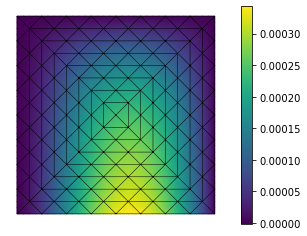

In [2]:
from skfem import *
from skfem.models.poisson import unit_load
import numpy as np

m = MeshTri.init_symmetric()
m.refine(3)

e = ElementTriMorley()
ib = InteriorBasis(m, e)


@BilinearForm
def bilinf(u, v, w):
    from skfem.helpers import dd, ddot, trace, eye
    d = 0.1
    E = 200e9
    nu = 0.3

    def C(T):
        return E / (1 + nu) * (T + nu / (1 - nu) * eye(trace(T), 2))

    return d**3 / 12.0 * ddot(C(dd(u)), dd(v))


K = asm(bilinf, ib)
f = 1e6 * asm(unit_load, ib)

dofs = ib.find_dofs({
    'left':  m.facets_satisfying(lambda x: x[0] == 0),
    'right': m.facets_satisfying(lambda x: x[0] == 1),
    'top':   m.facets_satisfying(lambda x: x[1] == 1),
})

D = np.concatenate((
    dofs['left'].nodal['u'],
    dofs['left'].facet['u_n'],
    dofs['right'].nodal['u'],
    dofs['top'].nodal['u'],
))

x = solve(*condense(K, f, D=D))

if __name__ == "__main__":
    from os.path import splitext
    from sys import argv
    from skfem.visuals.matplotlib import *
    ax = draw(m)
    plot(ib, x, ax=ax, shading='gouraud', colorbar=True, Nrefs=2)
    savefig(splitext(argv[0])[0] + '_solution.png')
